## Airbnb Marchine Learning


In [33]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import f_classif, SelectKBest

In [35]:
ruta = r"/workspaces/aliasys-procesamiento-de-datos/data/raw/AB_NYC_2019.csv"

# Cargar los datos desde el enlace
total_data = pd.read_csv(ruta)

# Mostrar primeras filas
total_data.head()


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [36]:
# Mostrar la forma del DataFrame
total_data.shape

(48895, 16)

In [37]:
# Mostrar información del DataFrame
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [38]:
# Eliminar las columnas que no son necesarias
total_data.drop(["id", "name", "host_name", "last_review", "reviews_per_month", "number_of_reviews"], axis=1, inplace=True)

In [39]:
# Eliminar duplicados innecesarios
total_data.drop_duplicates(inplace=True)

In [40]:
# Eliminar filas con valores nulos
total_data.dropna(inplace=True)

In [41]:
# Mostrar estadísticas descriptivas
total_data.describe()


,host_id,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365
count,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,7.143982,112.781327
std,7.861097e+07,0.054530,0.046157,240.154170,20.510550,32.952519,131.622289
min,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,1.000000,0.000000
25%,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.000000
50%,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,1.000000,45.000000
75%,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,2.000000,227.000000
max,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,327.000000,365.000000


## Observaciones:
- Cargamos el Dataset
- Nos fijamos que 'id', 'name', 'host_name', 'last_review', 'reviews_per_month y 'number_of_reviews' no las necesitamos para poder predecir el valor del precio de las habitaciones.
- Procedemos tambien a elimiar los duplicados.

# Analisis univariado de las variables

In [42]:
total_data

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
0,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,6,365
1,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,2,355
2,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,1,365
3,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,1,194
4,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,1,0
...,...,...,...,...,...,...,...,...,...,...
48890,8232441,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,2,9
48891,6570630,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,2,36
48892,23492952,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,1,27
48893,30985759,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,6,2


- Analizamos las variables categoricas:

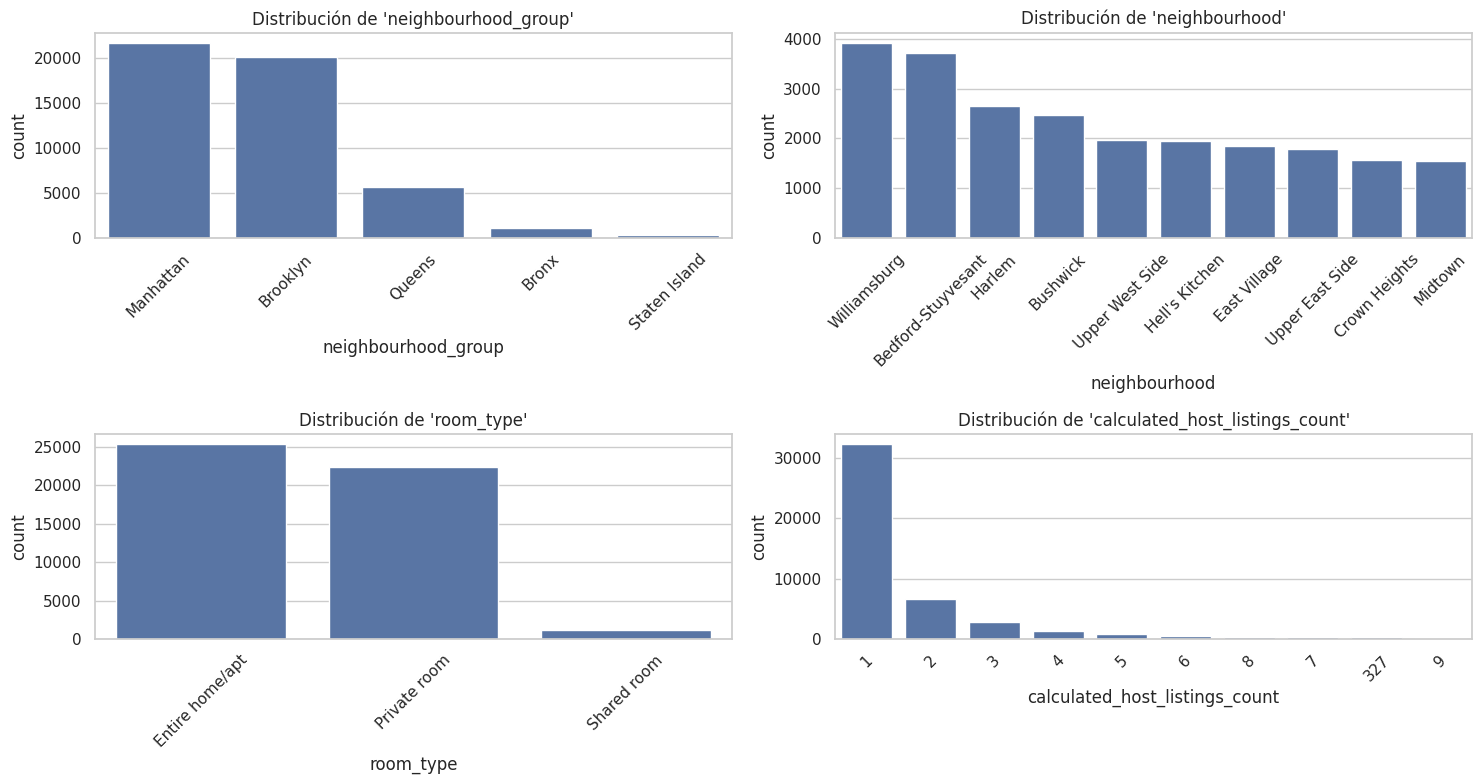

In [43]:
# Convertir las variables categóricas a tipo 'category'
cat_vars =['neighbourhood_group', 'neighbourhood', 'room_type', 'calculated_host_listings_count']

# Crear subplots: 2 columnas, n filas (según número de variables)
n = len(cat_vars)
cols = 2
rows = (n + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
axes = axes.flatten()

# Plot de cada variable categórica
for i, col in enumerate(cat_vars):
    sns.countplot(data=total_data, x=col, order=total_data[col].value_counts().index[:10], ax=axes[i])
    axes[i].set_title(f"Distribución de '{col}'")
    axes[i].tick_params(axis='x', rotation=45)

# Eliminar subplots sobrantes si los hay
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Observaciones:
- La mayoría de los anuncios son para departamentos completos (Entire home/apt), seguidos por habitaciones privadas. Esto indica que los usuarios prefieren privacidad y comodidad.
- La mayoría de los alojamientos permiten estancias cortas (1 o 2 noches), aunque hay algunos con requisitos más largos, destinados a estancias prolongadas o alquileres temporales.
- La mayoría de los anfitriones tienen solo un listado, indicando que la mayoría son particulares que alquilan su propiedad.
- Hay muchísimos vecindarios, pero solo unos pocos concentran la mayoría de los anuncios (como Williamsburg, Harlem, Bedford-Stuyvesant). La mayoría de los vecindarios tienen muy pocos registros.
- Hay una fuerte concentración de alojamientos en zonas turísticas. Manhattan y Brooklyn dominan claramente en cantidad de alojamientos. Queens, Bronx y Staten Island tienen mucha menos oferta.

### Analizamos las varibles numericas

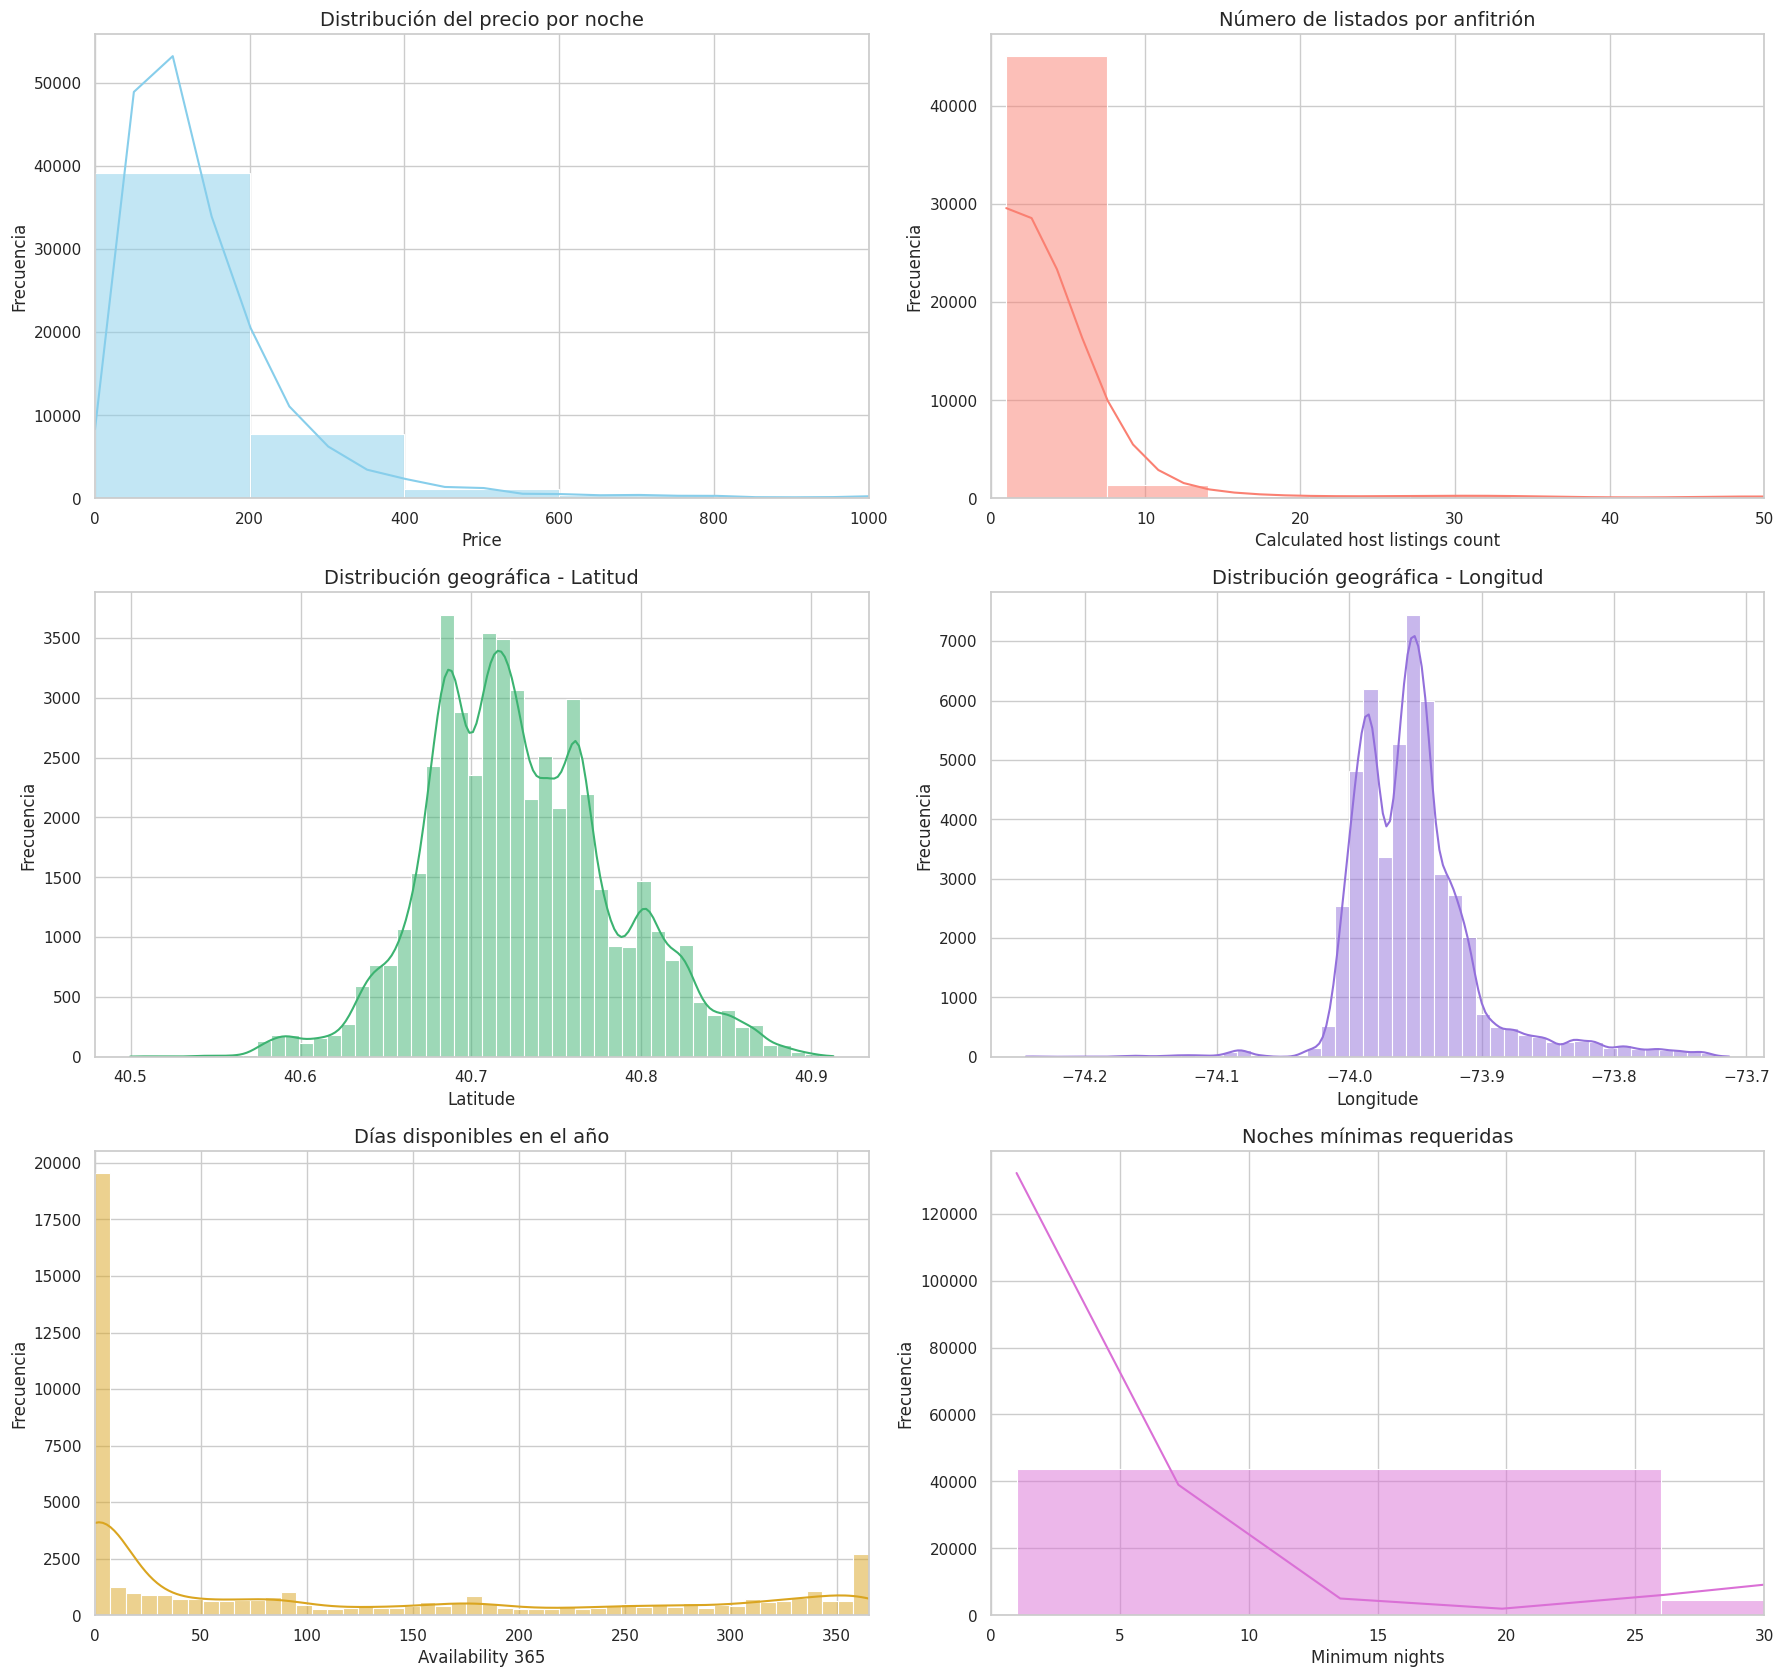

In [44]:
# Activar estilo Seaborn
sns.set(style="whitegrid")

# Crear figura con 4 filas y 2 columnas
fig, axes = plt.subplots(4, 2, figsize=(18, 22))
axes = axes.flatten()  # Aplanar para indexar fácilmente
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Lista de pares (título, columna, color, xlim opcional)
plots = [
    ("Distribución del precio por noche", "price", 'skyblue', (0, 1000)),
    ("Número de listados por anfitrión", "calculated_host_listings_count", 'salmon', (0, 50)),
    ("Distribución geográfica - Latitud", "latitude", 'mediumseagreen', None),
    ("Distribución geográfica - Longitud", "longitude", 'mediumpurple', None),
    ("Días disponibles en el año", "availability_365", 'goldenrod', (0, 365)),
    ("Noches mínimas requeridas", "minimum_nights", 'orchid', (0, 30))
]

# Crear cada histograma
for i, (title, column, color, xlim) in enumerate(plots):
    sns.histplot(data=total_data, x=column, bins=50, kde=True, ax=axes[i], color=color)
    axes[i].set_title(title, fontsize=14)
    axes[i].set_xlabel(column.replace("_", " ").capitalize())
    axes[i].set_ylabel("Frecuencia")
    if xlim:
        axes[i].set_xlim(xlim)

# Eliminar subplots vacíos
for j in range(len(plots), len(axes)):
    fig.delaxes(axes[j])

# Ajustar diseño
plt.tight_layout()
plt.show()



# Analisis de la grafica :
- En la grafica del precio: Fuerte asimetría a la derecha (muchos valores bajos, pocos valores muy altos). La mayoría de los precios parecen estar por debajo de $500, con algunos outliers extremos (> $1000)
- En la grafica de listados por host (calculated_host_listings_count): La mayoría de los hosts tienen solo 1 listing. Hay una minoría significativa que tiene múltiples propiedades (hosts profesionales).
- En la grafica de latitud y longitude (latitude) y (longitude): La latitud y longitud están concentradas en rangos específicos, como se espera en un mapa geográfico. Puedes ver la forma de la ciudad (Nueva York), con mayor densidad en ciertas zonas.
- En la grafica de disponibilidad anual (availability_365): Picos en valores 0 días (no disponible) y 365 días (siempre disponible).Muchas propiedades solo están parcialmente disponibles.
- En la grafica de noches mínimas (minimum_nights): La mayoría de los anuncios tienen un mínimo bajo (1 a 3 noches). Pero hay un número considerable con valores extremos, incluso mayores a 100.


# Analisis entre categoricas y numericas

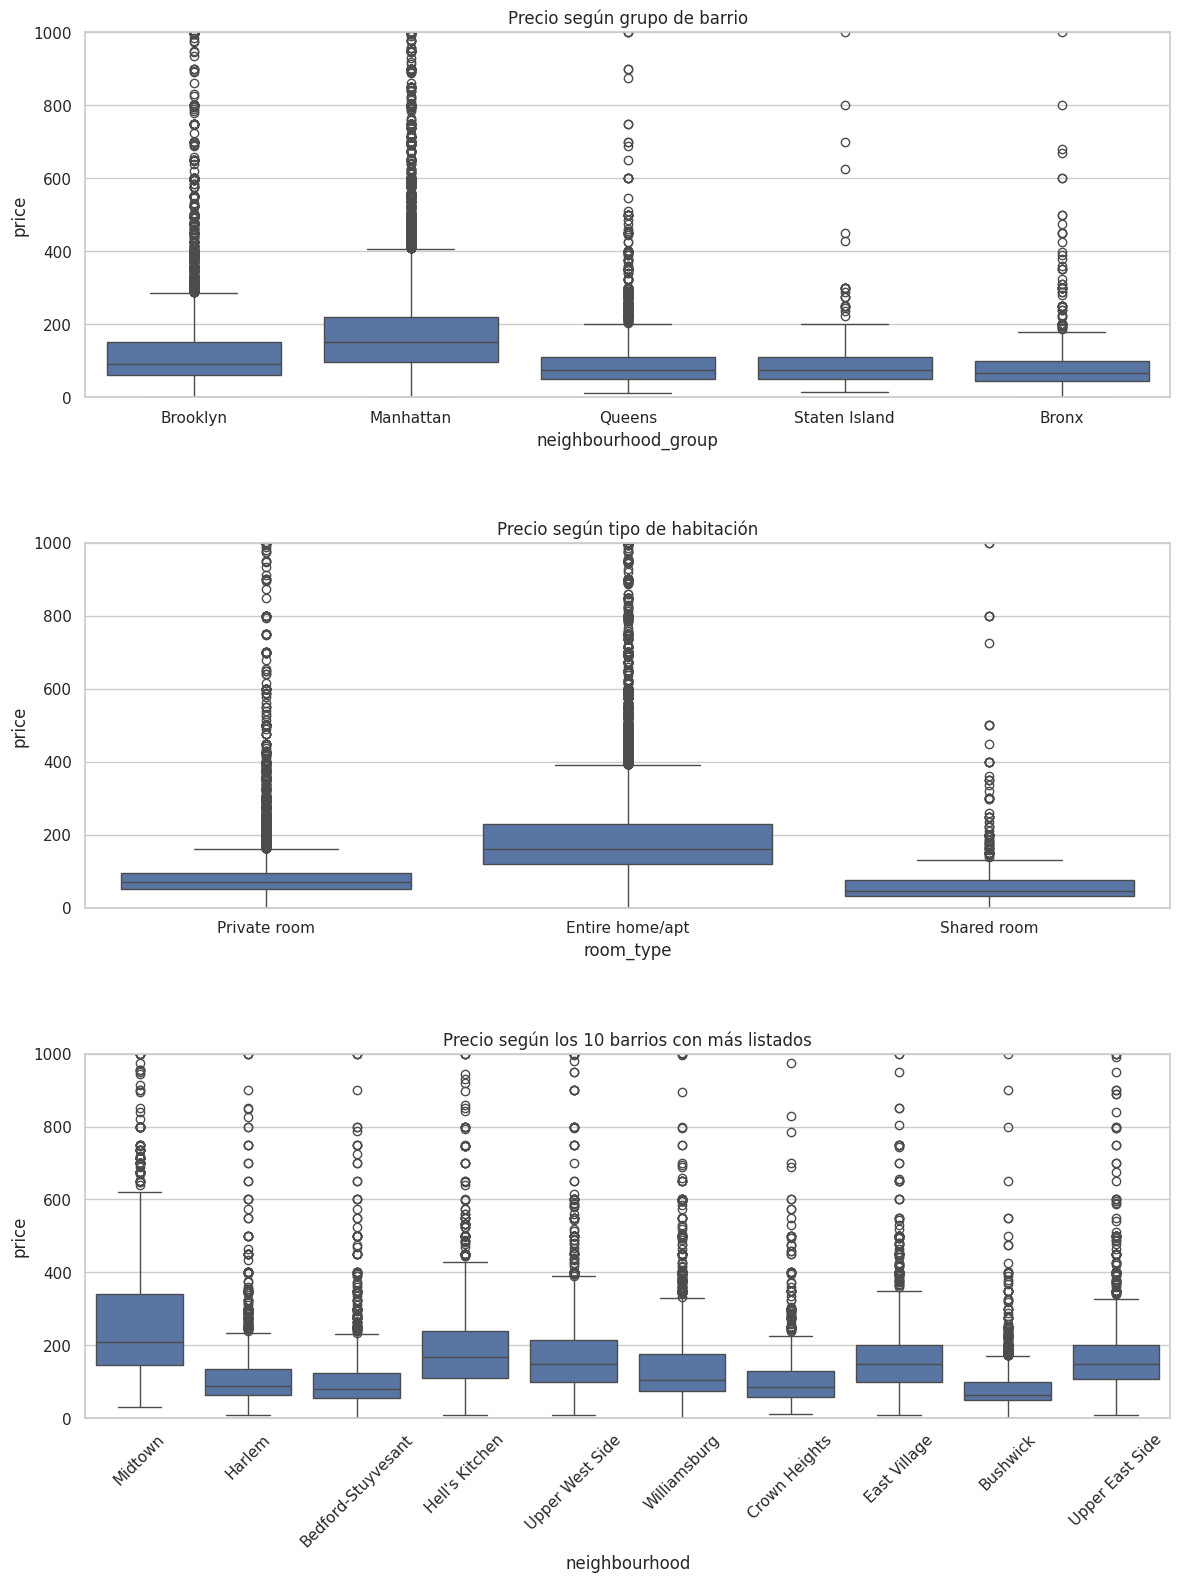

In [45]:
# Activar el estilo seaborn
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(14, 18))
plt.subplots_adjust(hspace=0.4)

# 1. Price vs Neighbourhood Group
sns.boxplot(data=total_data, x="neighbourhood_group", y="price", ax=axes[0])
axes[0].set_title("Precio según grupo de barrio")
axes[0].set_ylim(0, 1000)  # Limitar para evitar outliers extremos

# 2. Price vs Room Type
sns.boxplot(data=total_data, x="room_type", y="price", ax=axes[1])
axes[1].set_title("Precio según tipo de habitación")
axes[1].set_ylim(0, 1000)

# 3. Price vs Neighbourhood (solo top 10 barrios para claridad)
top10_neigh = total_data['neighbourhood'].value_counts().nlargest(10).index
sns.boxplot(data=total_data[total_data['neighbourhood'].isin(top10_neigh)],
            x="neighbourhood", y="price", ax=axes[2])
axes[2].set_title("Precio según los 10 barrios con más listados")
axes[2].set_ylim(0, 1000)
axes[2].tick_params(axis='x', rotation=45)

plt.show()

### Observamos:

- - La ubicación (neighbourhood_group y neighbourhood) es uno de los factores más determinantes del precio.
- Manhattan, siendo el centro turístico y económico, presenta precios significativamente más altos.
- Otros boroughs como Bronx o Staten Island tienen precios notablemente más bajos. Dentro de cada borough, algunos vecindarios premium elevan el precio aún más.
- El tipo de habitación afecta fuertemente el precio. Alquilar un apartamento entero (entire home/apt) cuesta sustancialmente más que una habitación privada o compartida. Esto refleja el valor añadido de la privacidad y espacio.
- Los precios tienen alta variabilidad y muchos outliers.
- Existen listados con precios muy altos, que pueden ser propiedades de lujo o errores. Esto sugiere que, para modelar o predecir precios, es importante manejar adecuadamente estos outliers (p. ej. transformaciones o límites). Para predecir precios, la combinación de ubicación y tipo de habitación es fundamental

Procdemos a correlacionar los conceptos para entender mejor las graficas, tanto las categoricas como las numericas

- Pasamos 'room_type', 'neighbourhood_group' y 'neighbourhood' a numerica para poder correlacionar bien las variables.

In [46]:
cols_to_encode = ['neighbourhood_group', 'neighbourhood', 'room_type']
label_encoders = {}

for col in cols_to_encode:
    le = LabelEncoder()
    total_data[col] = le.fit_transform(total_data[col])
    label_encoders[col] = le  # Guardar para revertir si quieres

# Ahora esas columnas tienen valores enteros (0, 1, 2, ...)

In [47]:
# Ruta completa del directorio donde guardarás el archivo
output_dir = r"/workspaces/aliasys-procesamiento-de-datos/data/processed/"
output_file = os.path.join(output_dir, "datos_label_encoded.json")
# Guardar el archivo JSON
total_data.to_json(output_file, orient="records", lines=True)

In [48]:
total_data

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
0,2787,1,108,40.64749,-73.97237,1,149,1,6,365
1,2845,2,127,40.75362,-73.98377,0,225,1,2,355
2,4632,2,94,40.80902,-73.94190,1,150,3,1,365
3,4869,1,41,40.68514,-73.95976,0,89,1,1,194
4,7192,2,61,40.79851,-73.94399,0,80,10,1,0
...,...,...,...,...,...,...,...,...,...,...
48890,8232441,1,13,40.67853,-73.94995,1,70,2,2,9
48891,6570630,1,28,40.70184,-73.93317,1,40,4,2,36
48892,23492952,2,94,40.81475,-73.94867,0,115,10,1,27
48893,30985759,2,95,40.75751,-73.99112,2,55,1,6,2


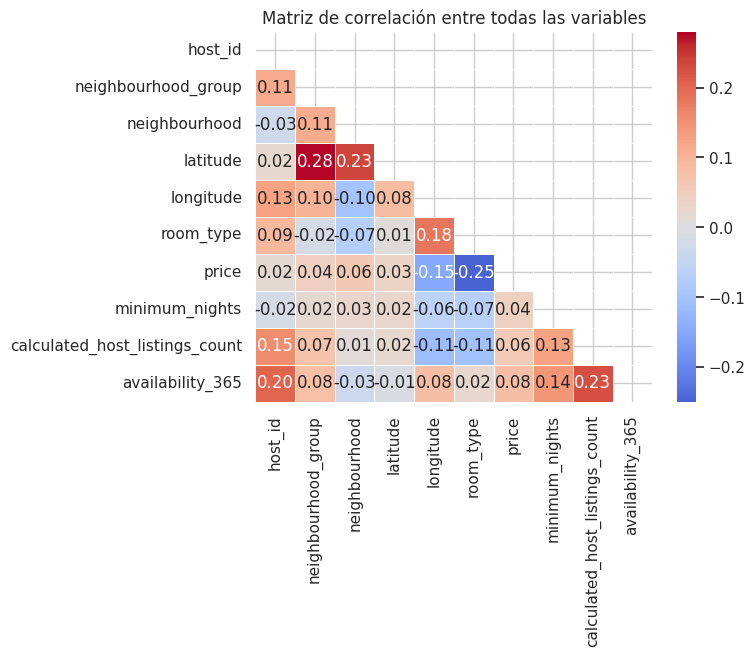

In [49]:
# Calcular la matriz de correlación
corr_matrix = total_data.corr()

# Visualizar con un heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0, annot=True, fmt=".2f", linewidths=0.5)

plt.title('Matriz de correlación entre todas las variables')
plt.show()

### Observaciones:
> - Existe una correlación moderada (r = 0.28) entre 'latitude' y 'neighbourhood_group', que probablemente refleja una relación geográfica esperada: los grupos vecinales están distribuidos en distintas latitudes (norte-sur) dentro de la ciudad.
> - Existe una correlación positiva débil (r = 0.23) entre 'availability_365' y 'calculated_host_listings_count', lo cual sugiere que los anfitriones con más propiedades tienden a tener sus alojamientos disponibles más días del año. Esta relación es consistente con la presencia de anfitriones profesionales o comerciales en la plataforma.
> - Se observa una correlación positiva débil (r = 0.14) entre la disponibilidad anual del alojamiento ('availability_365') y el mínimo de noches exigidas ('minimum_nights'). Esto sugiere que los alojamientos más disponibles tienden a requerir estancias mínimas ligeramente más largas, posiblemente como estrategia para optimizar su gestión y rentabilidad.
> - Existe una correlación positiva débil (r = 0.13) entre la cantidad de propiedades que tiene un anfitrión ('calculated_host_listings_count') y el mínimo de noches ('minimum_nights') requeridas por anuncio. Esto indica que los anfitriones con más propiedades tienden ligeramente a establecer estadías mínimas más largas, probablemente como estrategia de operación profesional.
> -Existe una correlación negativa moderada (r = -0.25) entre 'room_type' y 'price', lo que indica que el tipo de habitación influye claramente en el precio, siendo las habitaciones completas más caras, y las privadas o compartidas más económicas.
> - La correlación negativa débil (r = -0.15) entre 'price' y 'longitude' indica que los alojamientos ubicados más al este tienden a tener precios ligeramente más bajos, mientras que los que están más al oeste suelen ser un poco más caros. Esta tendencia podría reflejar la distribución geográfica del valor inmobiliario o atractivo turístico dentro de la ciudad.
> - Existe una correlación positiva débil (r = 0.18) entre 'room_type' y 'longitude', indicando que los tipos de habitación con valores más altos están ligeramente más ubicados hacia el este de la ciudad, lo cual puede reflejar patrones geográficos y socioeconómicos de la oferta de alojamiento.
>
#### Conclusion:
> - La matriz de correlación muestra que la ubicación geográfica y el tipo de habitación son factores clave que afectan los precios y la oferta del alojamiento, reflejando diferencias territoriales y socioeconómicas en la ciudad. Al mismo tiempo, los patrones de disponibilidad y condiciones mínimas de estadía están ligados al perfil del anfitrión, diferenciando entre usuarios ocasionales y profesionales/comerciales.
>
> - Estos hallazgos pueden guiar tanto estrategias de segmentación, fijación de precios y marketing, como la mejora de modelos predictivos que incorporen variables geográficas y operativas para entender mejor el comportamiento del mercado.

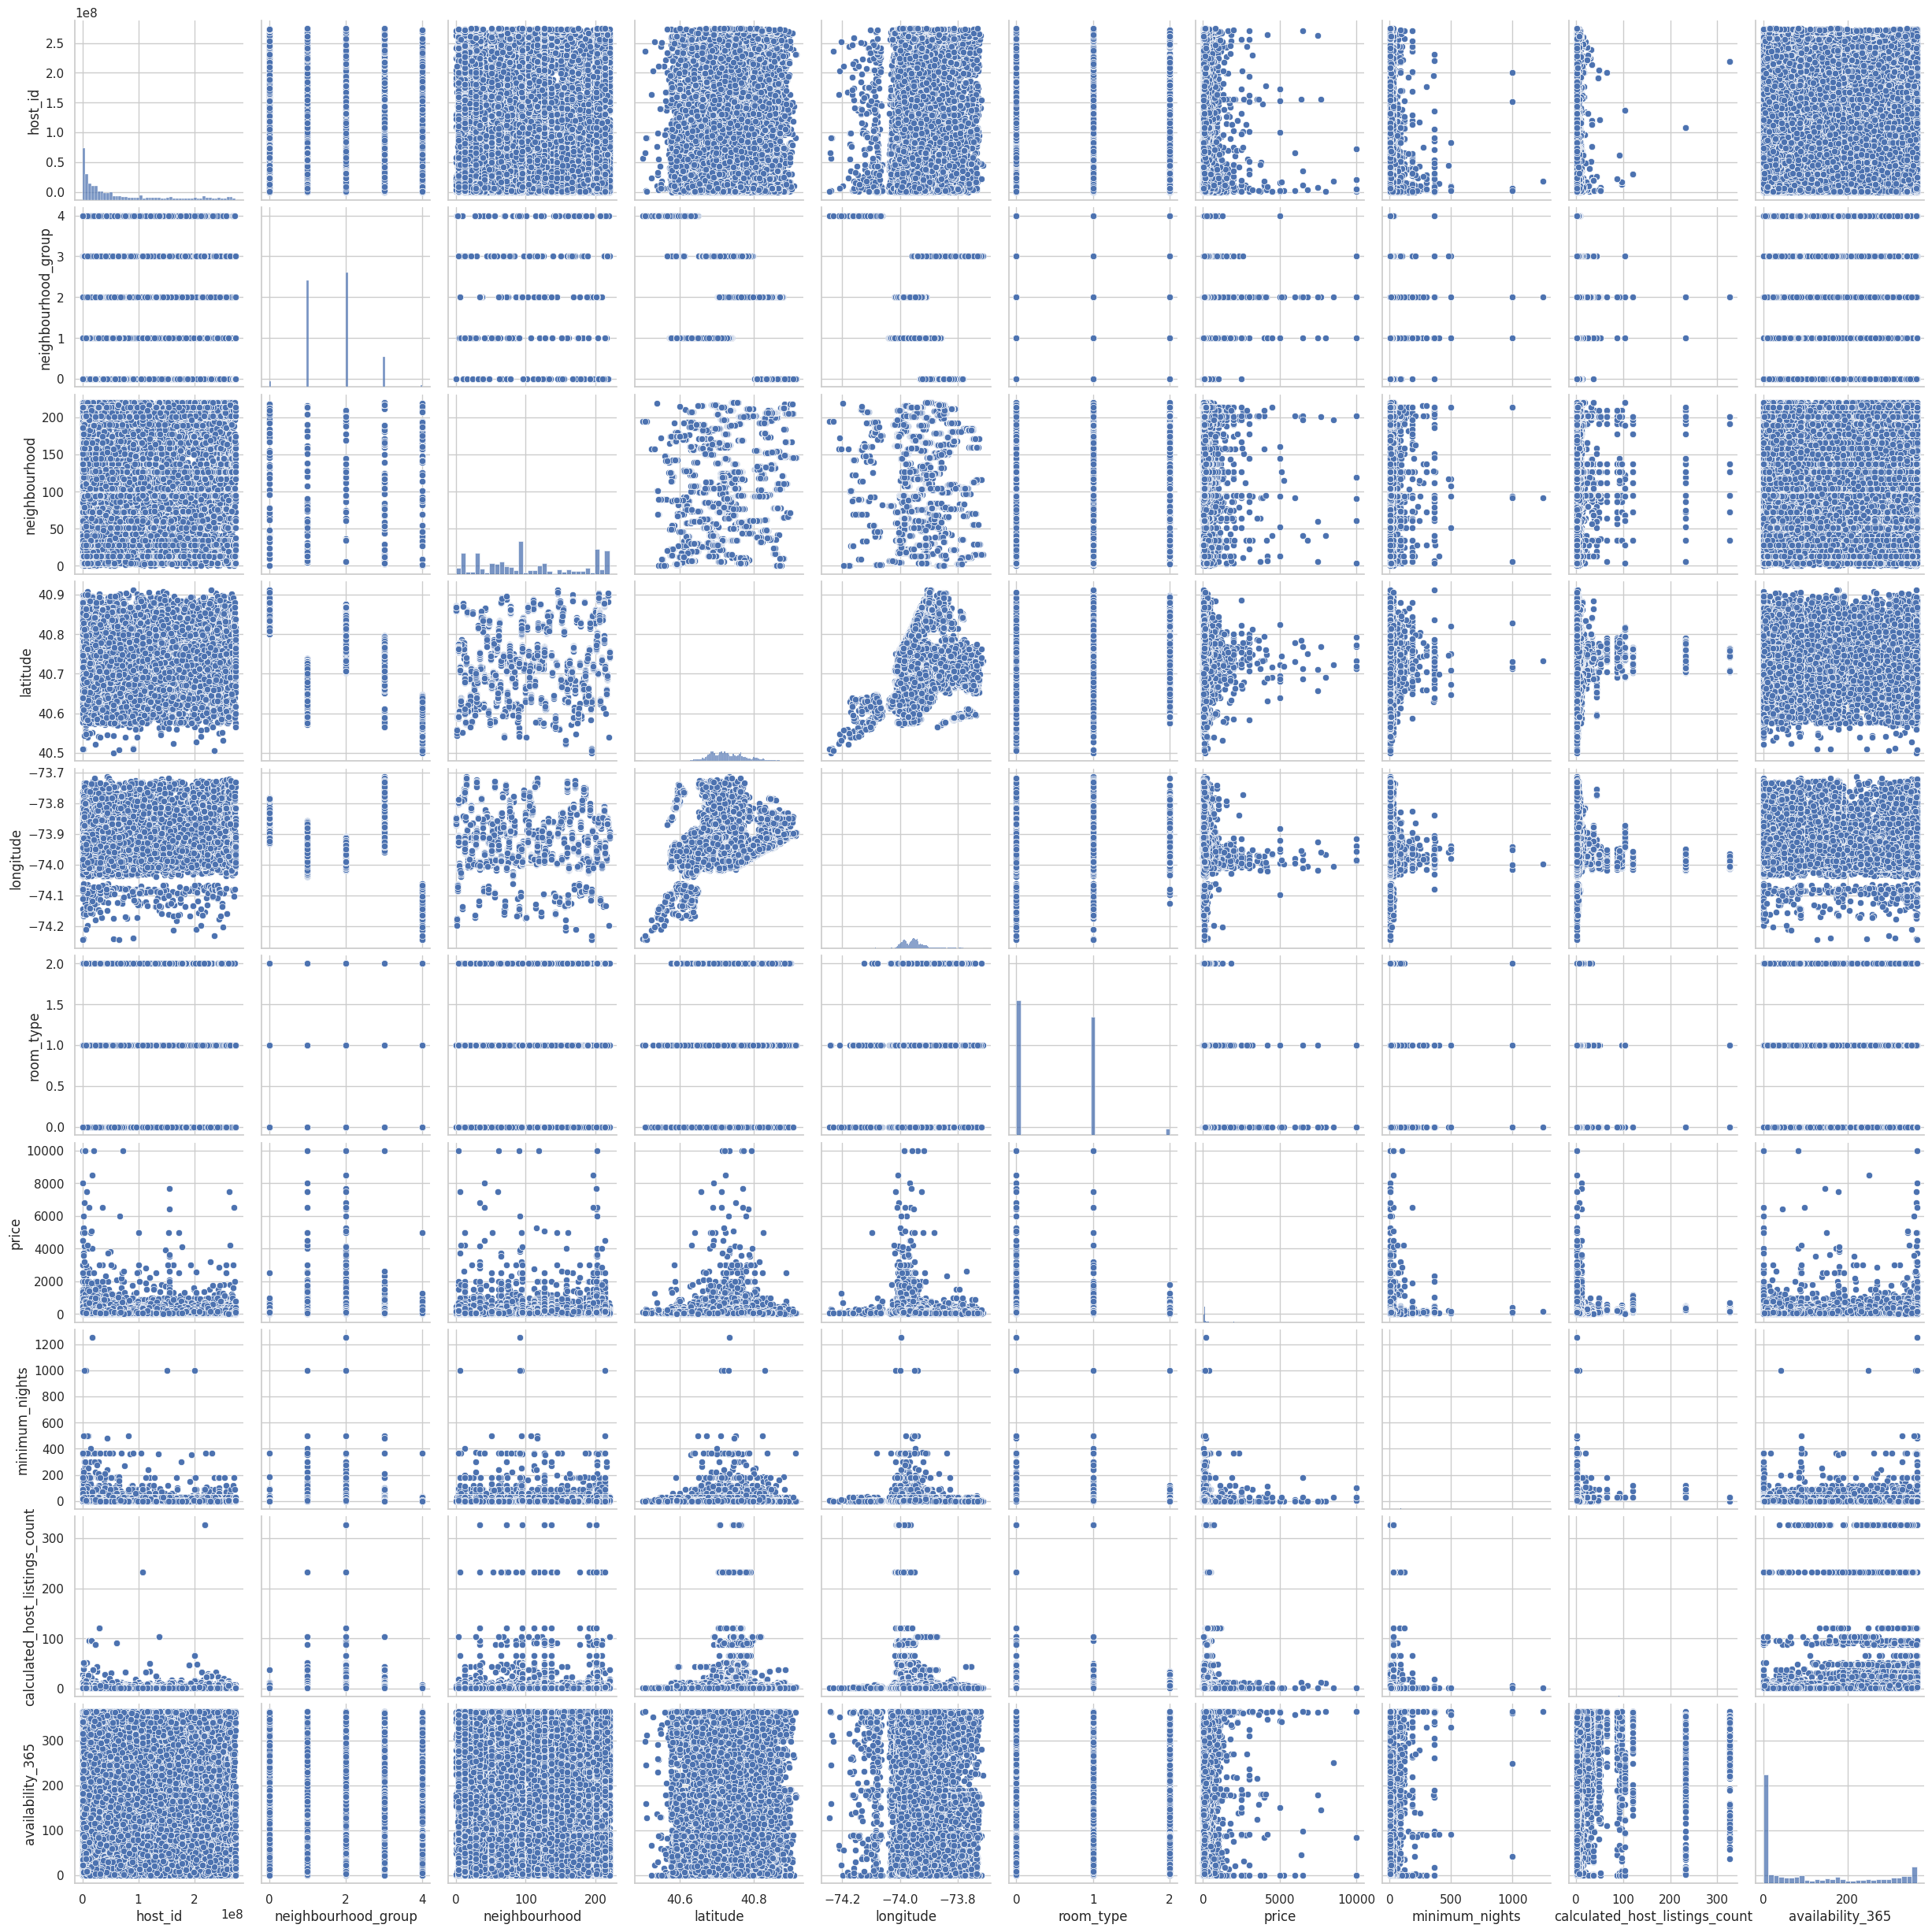

In [50]:
sns.pairplot(data=total_data)



## Paso 2

# Ingenieria de caracteristicas

In [55]:
# Buscamos si tenemos valores nulos en el DataFrame
total_data.isnull().sum().sort_values(ascending=False) / len(total_data)

host_id                           0.0
neighbourhood_group               0.0
neighbourhood                     0.0
latitude                          0.0
longitude                         0.0
room_type                         0.0
price                             0.0
minimum_nights                    0.0
calculated_host_listings_count    0.0
availability_365                  0.0
dtype: float64

# Analisis de outliers

In [56]:
total_data.describe()

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
count,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,6.762001e+07,1.675345,107.122732,40.728949,-73.952170,0.504060,152.720687,7.029962,7.143982,112.781327
std,7.861097e+07,0.735816,68.743096,0.054530,0.046157,0.545379,240.154170,20.510550,32.952519,131.622289
min,2.438000e+03,0.000000,0.000000,40.499790,-74.244420,0.000000,0.000000,1.000000,1.000000,0.000000
25%,7.822033e+06,1.000000,51.000000,40.690100,-73.983070,0.000000,69.000000,1.000000,1.000000,0.000000
50%,3.079382e+07,2.000000,94.000000,40.723070,-73.955680,0.000000,106.000000,3.000000,1.000000,45.000000
75%,1.074344e+08,2.000000,178.000000,40.763115,-73.936275,1.000000,175.000000,5.000000,2.000000,227.000000
max,2.743213e+08,4.000000,220.000000,40.913060,-73.712990,2.000000,10000.000000,1250.000000,327.000000,365.000000


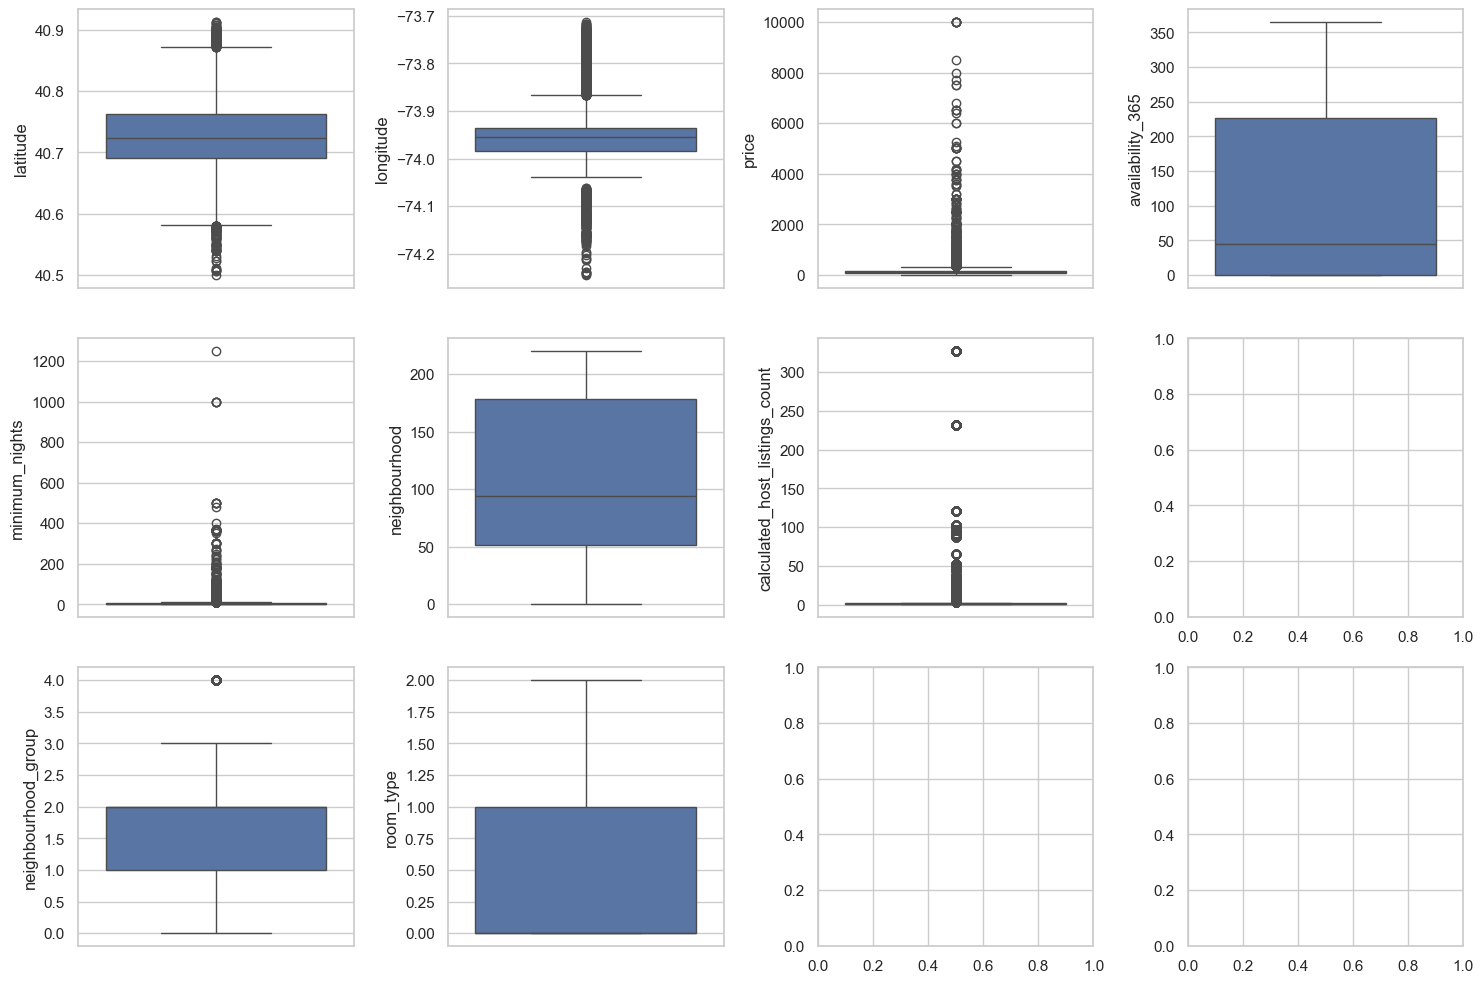

In [57]:
# Creamos subplots para detectar valores atípicos
fig, axis = plt.subplots(3, 4, figsize=(15, 10))

sns.boxplot(ax = axis[0, 0], data = total_data, y = "latitude")
sns.boxplot(ax = axis[0, 1], data = total_data, y = "longitude")
sns.boxplot(ax = axis[0, 2], data = total_data, y = "price")
sns.boxplot(ax = axis[1, 0], data = total_data, y = "minimum_nights")
sns.boxplot(ax = axis[1, 1], data = total_data, y = "neighbourhood")
sns.boxplot(ax = axis[1, 2], data = total_data, y = "calculated_host_listings_count")
sns.boxplot(ax = axis[2, 1], data = total_data, y = "room_type")
sns.boxplot(ax = axis[0, 3], data = total_data, y = "availability_365")
sns.boxplot(ax = axis[2, 0], data = total_data, y = "neighbourhood_group")


plt.tight_layout()
plt.show()


## Observaciones: 
- Encontramos que 'price', 'latitude', longitude', 'minimimum_ninghts', 'number_of_reviews', 'calculated_host_listings_count' y 'reviews_per_month' tienen valores atipicos, los cuales tenmos que analizar.


- Valor atipico en ['price']

In [58]:
price_stats = total_data["price"].describe()
price_stats

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

In [59]:
iqr_price = price_stats["75%"] - price_stats["25%"]
upper_price = price_stats["75%"] + 1.5 * iqr_price
lower_price = price_stats["25%"] - 1.5 * iqr_price
f"Los límites superior e inferior para la búsqueda de outliers son {round(upper_price, 2)} y {round(lower_price, 2)}, con un rango intercuartílico de {round(iqr_price, 2)}"

'Los límites superior e inferior para la búsqueda de outliers son 334.0 y -90.0, con un rango intercuartílico de 106.0'

### Hallazgos:
- Dado que los precios no pueden ser negativos, el límite inferior de -90.0 no tiene sentido práctico en este contexto.
- Por lo tanto, sólo los precios mayores a 334.0 deben considerarse como outliers.

> Esto indica que:

- La mayoría de los alojamientos están por debajo de los $334.
- Los precios significativamente mayores a eso podrían representar propiedades de lujo.

> En resumen: 
- No eliinimanos lo outliers pues parece que todo esta relacionados con ellos.

In [60]:
total_data[total_data["price"] > 300]
total_data

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
0,2787,1,108,40.64749,-73.97237,1,149,1,6,365
1,2845,2,127,40.75362,-73.98377,0,225,1,2,355
2,4632,2,94,40.80902,-73.94190,1,150,3,1,365
3,4869,1,41,40.68514,-73.95976,0,89,1,1,194
4,7192,2,61,40.79851,-73.94399,0,80,10,1,0
...,...,...,...,...,...,...,...,...,...,...
48890,8232441,1,13,40.67853,-73.94995,1,70,2,2,9
48891,6570630,1,28,40.70184,-73.93317,1,40,4,2,36
48892,23492952,2,94,40.81475,-73.94867,0,115,10,1,27
48893,30985759,2,95,40.75751,-73.99112,2,55,1,6,2


## Siguente Valor atipico: 
- Valor atipico en ['minimum_nights']

In [61]:
# Hacemos lo mismo para "minimum_nights"
minimum_nights_stats = total_data["minimum_nights"].describe()
minimum_nights_stats

count    48895.000000
mean         7.029962
std         20.510550
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

In [62]:
iqr_minimum_nights = minimum_nights_stats["75%"] - minimum_nights_stats["25%"]
upper_minimum_nights = minimum_nights_stats["75%"] + 1.5 * iqr_minimum_nights
lower_minimum_nights = minimum_nights_stats["25%"] - 1.5 * iqr_minimum_nights
upper_minimum_nights
mensaje = (
    f"Los límites superior e inferior para la búsqueda de outliers son {round(upper_minimum_nights, 2)} y {round(lower_minimum_nights, 2)}, "
    f"con un rango intercuartílico de {round(iqr_minimum_nights, 2)}"
)
mensaje


'Los límites superior e inferior para la búsqueda de outliers son 11.0 y -5.0, con un rango intercuartílico de 4.0'

> # Observaciones:
> - Valores normales: la mayoría de los alojamientos permiten de 1 a 4 noches mínimas.
> - Valores atípicos (outliers): cualquier alojamiento que pida más de 8.5 noches mínimas se considera un outlier.
> - Límite inferior inválido: no es valido porque no hay estancias negativas.
> ## Procedimiento: 
> - Eliminamos los registros donde minimum_nights > 8.5 para limpiar datos extremos o posiblemente erróneos.

In [63]:
total_data = total_data[(total_data['minimum_nights'] > 0) & (total_data["minimum_nights"] < upper_minimum_nights)]
total_data

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
0,2787,1,108,40.64749,-73.97237,1,149,1,6,365
1,2845,2,127,40.75362,-73.98377,0,225,1,2,355
2,4632,2,94,40.80902,-73.94190,1,150,3,1,365
3,4869,1,41,40.68514,-73.95976,0,89,1,1,194
4,7192,2,61,40.79851,-73.94399,0,80,10,1,0
...,...,...,...,...,...,...,...,...,...,...
48890,8232441,1,13,40.67853,-73.94995,1,70,2,2,9
48891,6570630,1,28,40.70184,-73.93317,1,40,4,2,36
48892,23492952,2,94,40.81475,-73.94867,0,115,10,1,27
48893,30985759,2,95,40.75751,-73.99112,2,55,1,6,2


## Siguente valor atipico:
- Valor atipico en ['calculated_host_listings_count']

In [64]:
# Buscamos los outliers de "calculated_host_listings_count"
calculated_host_listings_count_stats = total_data["calculated_host_listings_count"].describe()
calculated_host_listings_count_stats

count    42255.000000
mean         3.393729
std         21.967966
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        327.000000
Name: calculated_host_listings_count, dtype: float64

In [65]:
iqr_calculated_host_listings_count = calculated_host_listings_count_stats["75%"] - calculated_host_listings_count_stats["25%"]
upper_calculated_host_listings_count = calculated_host_listings_count_stats["75%"] + 1.5 * iqr_calculated_host_listings_count
lower_calculated_host_listings_count = calculated_host_listings_count_stats["25%"] - 1.5 * iqr_calculated_host_listings_count
upper_calculated_host_listings_count
mensaje = (
    f"Los límites superior e inferior para la búsqueda de outliers son {round(upper_calculated_host_listings_count, 2)} y {round(lower_calculated_host_listings_count, 2)}, "
    f"con un rango intercuartílico de {round(iqr_calculated_host_listings_count, 2)}"
)
mensaje

'Los límites superior e inferior para la búsqueda de outliers son 3.5 y -0.5, con un rango intercuartílico de 1.0'

> # Observaciones:
> - Valores normales: La mayoría de los anfitriones poseen entre 1 y 3 propiedades.
> - Valores atípicos (outliers): Se consideran outliers aquellos anfitriones que tienen 4 o más propiedades (es decir, más de 3.5 en la práctica).
> - Límite inferior inválido:No hay anfitriones con menos de 1 propiedad, así que no se considera límite inferior.
> ## Procedimiento:
> - Filtramos y eliminamos anfitriones que tengan 4 o más propiedades para quedarte solo con los anfitriones individuales.

In [66]:
total_data = total_data[(total_data["calculated_host_listings_count"] > 0) & (total_data["calculated_host_listings_count"] < upper_calculated_host_listings_count)]
total_data

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
1,2845,2,127,40.75362,-73.98377,0,225,1,2,355
2,4632,2,94,40.80902,-73.94190,1,150,3,1,365
3,4869,1,41,40.68514,-73.95976,0,89,1,1,194
4,7192,2,61,40.79851,-73.94399,0,80,10,1,0
5,7322,2,137,40.74767,-73.97500,0,200,3,1,129
...,...,...,...,...,...,...,...,...,...,...
48889,107716952,3,105,40.69137,-73.80844,1,65,1,2,163
48890,8232441,1,13,40.67853,-73.94995,1,70,2,2,9
48891,6570630,1,28,40.70184,-73.93317,1,40,4,2,36
48892,23492952,2,94,40.81475,-73.94867,0,115,10,1,27


## Siguente valor atipico:
- Valor atipico en ['latitude']

In [67]:
latitude_stats = total_data["latitude"].describe()
latitude_stats

count    38136.000000
mean        40.728396
std          0.055215
min         40.499790
25%         40.689120
50%         40.721320
75%         40.763333
max         40.913060
Name: latitude, dtype: float64

In [69]:
iqr_latitude = latitude_stats["75%"] - latitude_stats["25%"]
upper_latitde = latitude_stats["75%"] + 1.5 * iqr_latitude
lower_latitude = latitude_stats["25%"] - 1.5 * iqr_latitude
upper_latitde
mensaje = (
    f"Los límites superior e inferior para la búsqueda de outliers son {round(upper_latitde, 2)} y {round(lower_latitude, 2)}, "
    f"con un rango intercuartílico de {round(iqr_latitude, 2)}"
)
mensaje

'Los límites superior e inferior para la búsqueda de outliers son 40.87 y 40.58, con un rango intercuartílico de 0.07'

> # Observaciones:
> - Valores normales: La mayoría de los alojamientos tienen latitudes entre aproximadamente 40.58 y 40.87 (estos son los límites inferior y superior basados en el rango intercuartílico).
> - Valores atípicos (outliers): Aquellos alojamientos con latitud menor a 40.58 o mayor a 40.87 pueden considerarse outliers, ya que están fuera del rango típico.
> - Límite inferior inválido: no tiene.
> ## Procedimiento:
> - Eliminamos los registros donde latitude > 40.58 <  para limpiar datos extremos o posiblemente erróneos.

In [70]:
total_data = total_data[(total_data["latitude"] > 0) & (total_data["latitude"] < upper_latitde)]
total_data

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
1,2845,2,127,40.75362,-73.98377,0,225,1,2,355
2,4632,2,94,40.80902,-73.94190,1,150,3,1,365
3,4869,1,41,40.68514,-73.95976,0,89,1,1,194
4,7192,2,61,40.79851,-73.94399,0,80,10,1,0
5,7322,2,137,40.74767,-73.97500,0,200,3,1,129
...,...,...,...,...,...,...,...,...,...,...
48889,107716952,3,105,40.69137,-73.80844,1,65,1,2,163
48890,8232441,1,13,40.67853,-73.94995,1,70,2,2,9
48891,6570630,1,28,40.70184,-73.93317,1,40,4,2,36
48892,23492952,2,94,40.81475,-73.94867,0,115,10,1,27


## Siguente valor atipico:
- Valor atipico en ['longitude']

In [71]:
longitude_stats = total_data["longitude"].describe()
longitude_stats

count    37946.000000
mean       -73.952402
std          0.045023
min        -74.244420
25%        -73.982307
50%        -73.955080
75%        -73.937050
max        -73.712990
Name: longitude, dtype: float64

In [72]:
iqr_longitude = longitude_stats["75%"] - longitude_stats["25%"]
upper_longitude = longitude_stats["75%"] + 1.5 * iqr_longitude
lower_longitude = longitude_stats["25%"] - 1.5 * iqr_longitude
upper_longitude
mensaje = (
    f"Los límites superior e inferior para la búsqueda de outliers son {round(upper_longitude, 2)} y {round(lower_longitude, 2)}, "
    f"con un rango intercuartílico de {round(iqr_longitude, 2)}"
)
mensaje

'Los límites superior e inferior para la búsqueda de outliers son -73.87 y -74.05, con un rango intercuartílico de 0.05'

> # Observaciones:
> - Valores normales: La mayoría de los alojamientos tienen longitud entre aproximadamente -74.03 y -73.87 (estos son los límites inferior y superior basados en el rango intercuartílico).
> - Valores atípicos (outliers): Aquellos alojamientos con longitud menor a -74.05 o mayor a -73.87 pueden considerarse outliers, ya que están fuera del rango típico.
> - Límite inferior inválido: no tiene.
> ## Procedimiento:
> - Eliminamos los registros donde  longitud sean  menores a -74.05 o mayores a -73.87 para limpiar datos extremos o posiblemente erróneos.

In [80]:
total_data = total_data[(total_data["longitude"] > -74.25) & (total_data["longitude"] < upper_longitude)]
total_data

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
1,2845,2,127,40.75362,-73.98377,0,225,1,2,355
2,4632,2,94,40.80902,-73.94190,1,150,3,1,365
3,4869,1,41,40.68514,-73.95976,0,89,1,1,194
4,7192,2,61,40.79851,-73.94399,0,80,10,1,0
5,7322,2,137,40.74767,-73.97500,0,200,3,1,129
...,...,...,...,...,...,...,...,...,...,...
48888,274321313,2,95,40.76392,-73.99183,1,125,4,1,31
48890,8232441,1,13,40.67853,-73.94995,1,70,2,2,9
48891,6570630,1,28,40.70184,-73.93317,1,40,4,2,36
48892,23492952,2,94,40.81475,-73.94867,0,115,10,1,27


# Analisis de valores faltantes

In [81]:
# Mostramos valores faltantes
missing_values = total_data.isnull().sum().sort_values(ascending=False)
missing_values

host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

# Inferencia de nuevas características

In [51]:
# Eleminamos las columnas que no nos dan informacion relevante a lo que nosotros bucamos
total_data = total_data.drop(['neighbourhood_group'], axis=1)

total_data

,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
0,2787,108,40.64749,-73.97237,1,149,1,6,365
1,2845,127,40.75362,-73.98377,0,225,1,2,355
2,4632,94,40.80902,-73.94190,1,150,3,1,365
3,4869,41,40.68514,-73.95976,0,89,1,1,194
4,7192,61,40.79851,-73.94399,0,80,10,1,0
...,...,...,...,...,...,...,...,...,...
48890,8232441,13,40.67853,-73.94995,1,70,2,2,9
48891,6570630,28,40.70184,-73.93317,1,40,4,2,36
48892,23492952,94,40.81475,-73.94867,0,115,10,1,27
48893,30985759,95,40.75751,-73.99112,2,55,1,6,2


In [84]:
total_data.shape


(36185, 8)

# Observacion:
> - Eliminamos las columnas de grupo de vecinos y listado del host pues no tienen relevancia activa en el precio de las habitaciones.

## Escalado de valores

In [52]:
num_variables = ["latitude", "longitude", "price", "minimum_nights", "room_type","calculated_host_listings_count", "availability_365", "neighbourhood"]

# Dividimos el conjunto de datos en muestras de train y test
X = total_data.drop("host_id", axis = 1)[num_variables]
y = total_data["host_id"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.head()

,latitude,longitude,price,minimum_nights,room_type,calculated_host_listings_count,availability_365,neighbourhood
32645,40.71577,-73.95530,295,3,0,1,1,214
23615,40.84917,-73.94048,70,2,1,1,0,206
31183,40.68993,-73.95947,58,2,1,2,0,13
29260,40.68427,-73.93118,75,3,0,1,267,13
7275,40.74705,-73.89564,38,5,1,1,0,220


# Observaciones:
> - Dividimos el conjunto de datos ya elaborado y modificado en x_train, x_text, y_train y y_text para modelarlo lo maximo posible.

# Escalado Minimi-Maximo

In [53]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scal = scaler.transform(X_train)
X_train_scal = pd.DataFrame(X_train_scal, index = X_train.index, columns = num_variables)

X_test_scal = scaler.transform(X_test)
X_test_scal = pd.DataFrame(X_test_scal, index = X_test.index, columns = num_variables)

X_train_scal.head()

,latitude,longitude,price,minimum_nights,room_type,calculated_host_listings_count,availability_365,neighbourhood
32645,0.522612,0.542691,0.0295,0.001601,0.0,0.000000,0.002740,0.972727
23615,0.845404,0.570660,0.0070,0.000801,0.5,0.000000,0.000000,0.936364
31183,0.460087,0.534821,0.0058,0.000801,0.5,0.003067,0.000000,0.059091
29260,0.446391,0.588212,0.0075,0.001601,0.0,0.000000,0.731507,0.059091
7275,0.598301,0.655286,0.0038,0.003203,0.5,0.000000,0.000000,1.000000


> - Utilizamos el escalado de Miinimo y Maximo
- Segun el escalado los valores estan en el rango [0, 1]

## Seleccion de caracteristicas

In [54]:
# Selección de características usando SelectKBest con f_classif

selection_model = SelectKBest(f_classif, k = 5)
selection_model.fit(X_train, y_train)
ix = selection_model.get_support()
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

X_train_sel.head()

/home/vscode/.local/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


,latitude,longitude,calculated_host_listings_count,availability_365,neighbourhood
0,40.71577,-73.95530,1.0,1.0,214.0
1,40.84917,-73.94048,1.0,0.0,206.0
2,40.68993,-73.95947,2.0,0.0,13.0
3,40.68427,-73.93118,1.0,267.0,13.0
4,40.74705,-73.89564,1.0,0.0,220.0


### Observaciones:
> - Escalamos segun el modelo f_classif

In [55]:
X_test_sel.head()

,latitude,longitude,calculated_host_listings_count,availability_365,neighbourhood
0,40.64354,-73.97777,1.0,189.0,108.0
1,40.70666,-73.90779,1.0,73.0,166.0
2,40.76116,-73.99016,1.0,0.0,95.0
3,40.70763,-74.01050,327.0,272.0,73.0
4,40.79658,-73.93287,1.0,30.0,61.0


In [56]:
X_train_sel["host_id"] = list(y_train)
X_test_sel["host_id"] = list(y_test)

- Guardamos los modelos ya optimizados y modelados
-

In [57]:
# Guardamos el DataFrame limpio en un nuevo archivo CSV
total_data.to_csv("/workspaces/aliasys-procesamiento-de-datos/cleaned_airbnb_data.csv", index=False)

In [58]:
# Guardar DataFrames de entrenamiento y prueba
X_train_sel.to_csv("/workspaces/aliasys-procesamiento-de-datos/X_train_selected.csv", index=False)
X_test_sel.to_csv("/workspaces/aliasys-procesamiento-de-datos/X_test_selected.csv", index=False)

In [59]:
# Guardamos los DataFrames escalados en archivos CSV
X_train_scal.to_csv("/workspaces/aliasys-procesamiento-de-datos/X_train_scaled.csv", index=False)
X_test_scal.to_csv("/workspaces/aliasys-procesamiento-de-datos/X_test_scaled.csv", index=False)
# Guardamos los DataFrames originales en archivos CSV

In [60]:
X_train.to_csv("/workspaces/aliasys-procesamiento-de-datos/data/processed/X_test_original.csv", index=False)
X_test.to_csv("/workspaces/aliasys-procesamiento-de-datos/X_test_original.csv", index=False)